In [1]:
## Importing required libraries
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from time import time
from sklearn.decomposition import PCA, FastICA
from sklearn.pipeline import Pipeline
import matplotlib
matplotlib.rcParams['figure.figsize'] = [20, 12]

In [2]:
def get_match_label(match):
    ''' Derives a label for a given match. '''
    
    #Define variables
    home_goals = match['home_team_goal']
    away_goals = match['away_team_goal']

    #Identify match label  
    if home_goals > away_goals:
        return 'Win'
    if home_goals == away_goals:
        return 'Draw'
    if home_goals < away_goals:
        return 'Defeat'

In [3]:
def get_last_matches(matches, date, team, x = 10):
    ''' Get the last x matches of a given team. '''
    
    #Filter team matches from matches
    team_matches = matches[(matches['home_team_api_id'] == team) | (matches['away_team_api_id'] == team)]
                           
    #Filter x last matches from team matches
    last_matches = team_matches[team_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:x,:]
    
    #Return last matches
    return last_matches

In [4]:
def get_last_matches_against_eachother(matches, date, home_team, away_team, x = 10):
    ''' Get the last x matches of two given teams. '''
    
    #Find matches of both teams
    home_matches = matches[(matches['home_team_api_id'] == home_team) & (matches['away_team_api_id'] == away_team)]    
    away_matches = matches[(matches['home_team_api_id'] == away_team) & (matches['away_team_api_id'] == home_team)]  
    total_matches = pd.concat([home_matches, away_matches])
    
    #Get last x matches
    try:    
        last_matches = total_matches[total_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:x,:]
    except:
        last_matches = total_matches[total_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:total_matches.shape[0],:]
        
        #Check for error in data
        if(last_matches.shape[0] > x):
            print("Error in obtaining matches")
            
    #Return data
    return last_matches

In [5]:
def convert_odds_to_prob(match_odds):
    ''' Converts bookkeeper odds to probabilities. '''
    
    #Define variables
    match_id = match_odds.loc[:,'match_api_id']
    bookkeeper = match_odds.loc[:,'bookkeeper']    
    win_odd = match_odds.loc[:,'Win']
    draw_odd = match_odds.loc[:,'Draw']
    loss_odd = match_odds.loc[:,'Defeat']
    
    #Converts odds to prob
    win_prob = 1 / win_odd
    draw_prob = 1 / draw_odd
    loss_prob = 1 / loss_odd
    
    total_prob = win_prob + draw_prob + loss_prob
    
    probs = pd.DataFrame()
    
    #Define output format and scale probs by sum over all probs
    probs.loc[:,'match_api_id'] = match_id
    probs.loc[:,'bookkeeper'] = bookkeeper
    probs.loc[:,'Win'] = win_prob / total_prob
    probs.loc[:,'Draw'] = draw_prob / total_prob
    probs.loc[:,'Defeat'] = loss_prob / total_prob
    
    #Return probs and meta data
    return probs

### Doing things now...

In [6]:
## Fetching data
#Connecting to database
path = "soccer_database.sqlite"  #Insert path here
conn = sqlite3.connect(path)

#Defining the number of jobs to be run in parallel during grid search
n_jobs = 2 #Insert number of parallel jobs here

#Fetching required data tables
player_data = pd.read_sql("SELECT * FROM Player;", conn)
player_stats_data = pd.read_sql("SELECT * FROM Player_Attributes;", conn)
team_data = pd.read_sql("SELECT * FROM Team;", conn)
match_data = pd.read_sql("SELECT * FROM Match where country_id = 1729;", conn)

match_data.head(5)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1729,1729,1729,2008/2009,1,2008-08-17 00:00:00,489042,10260,10261,1,...,10.00,1.28,5.5,12.00,1.30,4.75,10.0,1.29,4.50,11.00
1,1730,1729,1729,2008/2009,1,2008-08-16 00:00:00,489043,9825,8659,1,...,12.00,1.25,6.0,13.00,1.22,5.50,13.0,1.22,5.00,13.00
2,1731,1729,1729,2008/2009,1,2008-08-16 00:00:00,489044,8472,8650,0,...,1.73,5.50,3.8,1.65,5.00,3.40,1.7,4.50,3.40,1.73
3,1732,1729,1729,2008/2009,1,2008-08-16 00:00:00,489045,8654,8528,2,...,3.75,1.90,3.5,4.35,1.91,3.25,4.0,1.91,3.25,3.80
4,1733,1729,1729,2008/2009,1,2008-08-17 00:00:00,489046,10252,8456,4,...,3.75,1.90,3.5,4.35,1.91,3.25,4.0,1.91,3.30,3.75


In [7]:
with_team_names = match_data.merge(
    team_data, 
    how='inner', 
    left_on=['home_team_api_id'], 
    right_on=['team_api_id'], 
    suffixes=('', '_home')
).merge(
    team_data, 
    how='inner', 
    left_on=['away_team_api_id'], 
    right_on=['team_api_id'], 
    suffixes=('', '_away')
)
with_team_names.head(5)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,id_home,team_api_id,team_fifa_api_id,team_long_name,team_short_name,id_away,team_api_id_away,team_fifa_api_id_away,team_long_name_away,team_short_name_away
0,1729,1729,1729,2008/2009,1,2008-08-17 00:00:00,489042,10260,10261,1,...,3457,10260,11.0,Manchester United,MUN,3458,10261,13.0,Newcastle United,NEW
1,2494,1729,1729,2010/2011,1,2010-08-16 00:00:00,839802,10260,10261,3,...,3457,10260,11.0,Manchester United,MUN,3458,10261,13.0,Newcastle United,NEW
2,2913,1729,1729,2011/2012,13,2011-11-26 00:00:00,1024845,10260,10261,1,...,3457,10260,11.0,Manchester United,MUN,3458,10261,13.0,Newcastle United,NEW
3,3353,1729,1729,2012/2013,19,2012-12-26 00:00:00,1229300,10260,10261,4,...,3457,10260,11.0,Manchester United,MUN,3458,10261,13.0,Newcastle United,NEW
4,3693,1729,1729,2013/2014,15,2013-12-07 00:00:00,1474518,10260,10261,0,...,3457,10260,11.0,Manchester United,MUN,3458,10261,13.0,Newcastle United,NEW


In [8]:
import operator
import xml.etree.ElementTree as ET

def get_posession_things(data):
    last_value = 50
    try:
        tree = ET.fromstring(data)
        results = tree.findall('value')
        results_dict = dict((result.find('elapsed').text, result.find('homepos').text) for result in results)
        last_value = [value for key, value in sorted(results_dict.items(), key=operator.itemgetter(1), reverse=True)][0]
    except:
        pass
    
    return last_value

In [9]:
with_team_names.loc[:, 'home_possession'] = with_team_names.possession.apply(lambda x: get_posession_things(x))

In [10]:
with_team_names.loc[:, 'total_prob'] = 1./with_team_names.B365H + 1./with_team_names.B365D + 1./with_team_names.B365A
with_team_names.loc[:, 'pct_win_prob'] = (1./ with_team_names.B365H) / with_team_names.total_prob
with_team_names.head(5)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,team_long_name,team_short_name,id_away,team_api_id_away,team_fifa_api_id_away,team_long_name_away,team_short_name_away,home_possession,total_prob,pct_win_prob
0,1729,1729,1729,2008/2009,1,2008-08-17 00:00:00,489042,10260,10261,1,...,Manchester United,MUN,3458,10261,13.0,Newcastle United,NEW,56,1.047921,0.739744
1,2494,1729,1729,2010/2011,1,2010-08-16 00:00:00,839802,10260,10261,3,...,Manchester United,MUN,3458,10261,13.0,Newcastle United,NEW,64,1.048485,0.763006
2,2913,1729,1729,2011/2012,13,2011-11-26 00:00:00,1024845,10260,10261,1,...,Manchester United,MUN,3458,10261,13.0,Newcastle United,NEW,70,1.054155,0.677591
3,3353,1729,1729,2012/2013,19,2012-12-26 00:00:00,1229300,10260,10261,4,...,Manchester United,MUN,3458,10261,13.0,Newcastle United,NEW,57,1.050441,0.780312
4,3693,1729,1729,2013/2014,15,2013-12-07 00:00:00,1474518,10260,10261,0,...,Manchester United,MUN,3458,10261,13.0,Newcastle United,NEW,48,1.027399,0.636165


## Work out how good each team is

In [11]:
HISTORY = 10
k_factor = 32
elo_width = 400.

def calculate_new_elos(rating_a, rating_b, score_a, k_factor, elo_width):
    """Calculates and returns the new Elo ratings for two players.
    score_a is 1 for a win by player A, 0 for a loss by player A, or 0.5 for a draw.
    """

    e_a = expected_result(rating_a, rating_b, elo_width)
    e_b = 1. - e_a
    new_rating_a = rating_a + k_factor * (score_a - e_a)
    score_b = 1. - score_a
    new_rating_b = rating_b + k_factor * (score_b - e_b)
    return new_rating_a, new_rating_b

def expected_result(elo_a, elo_b, elo_width):
    """
    https://en.wikipedia.org/wiki/Elo_rating_system#Mathematical_details
    """
    expect_a = 1.0/(1+10**((elo_b - elo_a)/elo_width))
    return expect_a

def update_end_of_season(elos):
    """Regression towards the mean
    
    Following 538 nfl methods
    https://fivethirtyeight.com/datalab/nfl-elo-ratings-are-back/
    """
    diff_from_mean = elos - np.mean(elos)
    elos -= diff_from_mean/3
    return elos

In [77]:
team_elo = with_team_names.team_long_name.drop_duplicates().reset_index()
team_elo.loc[:, 'elo'] = 1000
team_elo = team_elo[['team_long_name', 'elo']]
with_team_names.loc[:, 'expected'] = 0.5
team_elo.head()

,team_long_name,elo
0,Manchester United,1000
1,Arsenal,1000
2,Sunderland,1000
3,West Ham United,1000
4,Aston Villa,1000


In [13]:
def calculate_result(row):
    if row.home_team_goal > row.away_team_goal:
        return 1
    elif row.home_team_goal == row.away_team_goal:
        return 0.5
    else:
        return 0

In [14]:
def create_predictions(team_elo, col_name, k_factor, elo_width):
    current_season = '2008/2009'
    for index, row in with_team_names.sort_values(by='date').iterrows():
        new_season = row.season
        if new_season != current_season:
            new_elos = update_end_of_season(team_elo.elo.values)
            team_elo.loc[:, 'elo'] = new_elos
            current_season = new_season

        home = row.team_long_name
        away = row.team_long_name_away
        home_elo = team_elo[team_elo.team_long_name == home].elo.values[0]
        away_elo = team_elo[team_elo.team_long_name == away].elo.values[0]
        expected_results = expected_result(home_elo, away_elo, elo_width)
        result = calculate_result(row)
        with_team_names.loc[index, col_name] = expected_results
        new_home_elo, new_away_elo = calculate_new_elos(home_elo, away_elo, result, k_factor, elo_width)
        team_elo.loc[team_elo.team_long_name == home, 'elo'] = new_home_elo
        team_elo.loc[team_elo.team_long_name == away, 'elo'] = new_away_elo

In [98]:
def new_elo(match):
    home = match.team_long_name.values[0]
    away = match.team_long_name_away.values[0]
    home_attack_elo = home_attack_elos[home_attack_elos.team_long_name == home].elo.values[0]
    away_defence_elo = away_defence_elos[away_defence_elos.team_long_name == away].elo.values[0]
    expected_home_goals = expected_goals(home_attack_elo, away_defence_elo, elo_width)
    home_goals = match.home_team_goal
    new_home_attack_elo, new_away_defence_elo = calculate_new_elos(home_attack_elo, away_defence_elo, home_goals, k_factor, elo_width)
    home_attack_elos.loc[home_attack_elos.team_long_name == home, 'elo'] = new_home_attack_elo
    away_defence_elos.loc[away_defence_elos.team_long_name == away, 'elo'] = new_away_defence_elo
    
def expected_goals(home_attack_elo, away_defense_elo, elo_width):
    return None

In [134]:
def create_elo_frame(team_frame, base):
    frame = team_frame.team_long_name.drop_duplicates().reset_index()
    frame.loc[:, 'elo'] = base
    frame = frame[['team_long_name', 'elo']]
    return frame

mean_home_goals = np.mean(with_team_names.home_team_goal.values)
mean_away_goals = np.mean(with_team_names.away_team_goal.values)
home_attack_elos = create_elo_frame(with_team_names, mean_home_goals)
away_attack_elos = create_elo_frame(with_team_names, mean_away_goals)
home_defence_elos = create_elo_frame(with_team_names, mean_away_goals)
away_defence_elos = create_elo_frame(with_team_names, mean_home_goals)

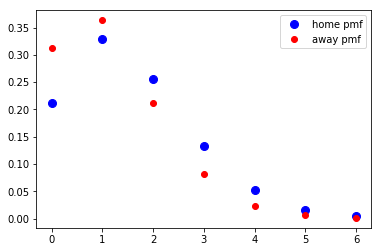

In [126]:
from scipy.stats import poisson,skellam
x = np.arange(poisson.ppf(0.01, mean_home_goals), poisson.ppf(0.999, mean_home_goals))
plt.plot(x, poisson.pmf(x, mean_home_goals), 'bo', ms=8, label='home pmf')
plt.plot(x, poisson.pmf(x, mean_away_goals), 'ro', label='away pmf')
#plt.vlines(x, 0, poisson.pmf(x, mean_home_goals), colors='b', lw=5, alpha=0.5)
plt.legend()
plt.show()

0.7768421052631579

In [122]:
other_mu

1.1626315789473685

In [133]:
poisson.expect?

In [60]:
team_elo.sort_values(by='elo', ascending=False).head()

,team_long_name,elo
16,Manchester City,1339.954779
13,Tottenham Hotspur,1211.726294
0,Manchester United,1196.060633
11,Liverpool,1163.958444
9,Chelsea,1106.927784


In [17]:
new_elos = update_end_of_season(team_elo.elo.values)
team_elo.loc[:, 'new_elo'] = new_elos
team_elo.sort_values(by='new_elo', ascending=False).head()

,team_long_name,elo,new_elo
16,Manchester City,1372.408171,1372.408171
13,Tottenham Hotspur,1245.959298,1245.959298
0,Manchester United,1230.343792,1230.343792
11,Liverpool,1207.243840,1207.243840
9,Chelsea,1157.595351,1157.595351


In [18]:
with_team_names.loc[:, 'resulty'] = with_team_names.apply(lambda x: calculate_result(x), axis=1)
with_team_names.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,team_api_id_away,team_fifa_api_id_away,team_long_name_away,team_short_name_away,home_possession,total_prob,pct_win_prob,expected,final_expected,resulty
0,1729,1729,1729,2008/2009,1,2008-08-17 00:00:00,489042,10260,10261,1,...,10261,13.0,Newcastle United,NEW,56,1.047921,0.739744,0.5,0.500000,0.5
1,2494,1729,1729,2010/2011,1,2010-08-16 00:00:00,839802,10260,10261,3,...,10261,13.0,Newcastle United,NEW,64,1.048485,0.763006,0.5,0.744386,1.0
2,2913,1729,1729,2011/2012,13,2011-11-26 00:00:00,1024845,10260,10261,1,...,10261,13.0,Newcastle United,NEW,70,1.054155,0.677591,0.5,0.648628,0.5
3,3353,1729,1729,2012/2013,19,2012-12-26 00:00:00,1229300,10260,10261,4,...,10261,13.0,Newcastle United,NEW,57,1.050441,0.780312,0.5,0.779633,1.0
4,3693,1729,1729,2013/2014,15,2013-12-07 00:00:00,1474518,10260,10261,0,...,10261,13.0,Newcastle United,NEW,48,1.027399,0.636165,0.5,0.629053,0.0


In [19]:
with_team_names.loc[:, 'label'] = with_team_names.apply(lambda x: get_match_label(x), axis=1)
with_team_names.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,team_fifa_api_id_away,team_long_name_away,team_short_name_away,home_possession,total_prob,pct_win_prob,expected,final_expected,resulty,label
0,1729,1729,1729,2008/2009,1,2008-08-17 00:00:00,489042,10260,10261,1,...,13.0,Newcastle United,NEW,56,1.047921,0.739744,0.5,0.500000,0.5,Draw
1,2494,1729,1729,2010/2011,1,2010-08-16 00:00:00,839802,10260,10261,3,...,13.0,Newcastle United,NEW,64,1.048485,0.763006,0.5,0.744386,1.0,Win
2,2913,1729,1729,2011/2012,13,2011-11-26 00:00:00,1024845,10260,10261,1,...,13.0,Newcastle United,NEW,70,1.054155,0.677591,0.5,0.648628,0.5,Draw
3,3353,1729,1729,2012/2013,19,2012-12-26 00:00:00,1229300,10260,10261,4,...,13.0,Newcastle United,NEW,57,1.050441,0.780312,0.5,0.779633,1.0,Win
4,3693,1729,1729,2013/2014,15,2013-12-07 00:00:00,1474518,10260,10261,0,...,13.0,Newcastle United,NEW,48,1.027399,0.636165,0.5,0.629053,0.0,Defeat


In [20]:
def get_home_recent_score(match, all_matches):
    last_matches = get_last_matches(
        all_matches,
        match.date,
        match.home_team_api_id,
        x = 10
    )
    score = calculate_team_score(last_matches, match)
    return score

def get_away_recent_score(match, all_matches):
    last_matches = get_last_matches(
        all_matches,
        match.date,
        match.away_team_api_id,
        x = 10
    )
    score = calculate_away_team_score(last_matches, match)
    return score

def get_team_score(match, all_matches):
    last_matches = get_last_matches_against_eachother(
        all_matches,
        match.date,
        match.home_team_api_id,
        match.away_team_api_id,
        x = 25
    )
    score = calculate_team_score(last_matches, match)
    return score

def calculate_team_score(matches, this_match):
    home_matches = matches[matches.home_team_api_id == this_match.home_team_api_id]
    away_matches = matches[matches.away_team_api_id == this_match.home_team_api_id]
    home_offensive_score, home_defensive_score = get_home_score(home_matches)
    away_offensive_score, away_defensive_score = get_away_score(away_matches)
    return (home_offensive_score, home_defensive_score, away_offensive_score, away_defensive_score)

def calculate_away_team_score(matches, this_match):
    home_matches = matches[matches.home_team_api_id == this_match.away_team_api_id]
    away_matches = matches[matches.away_team_api_id == this_match.away_team_api_id]
    home_offensive_score, home_defensive_score = get_home_score(home_matches)
    away_offensive_score, away_defensive_score = get_away_score(away_matches)
    return (home_offensive_score, home_defensive_score, away_offensive_score, away_defensive_score)

def get_home_score(matches):
    total_offensive_score = 0
    total_defensive_score = 0
    for index, match in enumerate(matches.itertuples(index=False, name='Pandas')):
        offensive_score = match.home_team_goal / (index + 1)
        defensive_score = match.away_team_goal / (index + 1)
        total_offensive_score += offensive_score
        total_defensive_score -= defensive_score
    return (total_offensive_score, total_defensive_score)

def get_away_score(matches):
    total_offensive_score = 0
    total_defensive_score = 0
    for index, match in enumerate(matches.itertuples(index=False, name='Pandas')):
        offensive_score = match.away_team_goal / (index + 1)
        defensive_score = match.home_team_goal / (index + 1)
        total_offensive_score += offensive_score
        total_defensive_score -= defensive_score
    return (total_offensive_score, total_defensive_score)

In [21]:
good = with_team_names.apply(lambda x: list(get_team_score(x, with_team_names)), axis=1)

In [22]:
match_stats = pd.DataFrame(good.tolist(), columns = ['home_offensive', 'home_defensive', 'away_offensive', 'away_defensive'])
match_stats.head()

,home_offensive,home_defensive,away_offensive,away_defensive
0,0.000000,0.000000,0.0,0.00
1,1.000000,-1.000000,2.0,-1.00
2,3.500000,-0.500000,1.0,-0.50
3,2.833333,-1.333333,3.5,-1.75
4,5.750000,-3.750000,3.5,-1.75


In [23]:
new_frame = pd.concat([with_team_names, match_stats], axis=1)
new_frame.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,total_prob,pct_win_prob,expected,final_expected,resulty,label,home_offensive,home_defensive,away_offensive,away_defensive
0,1729,1729,1729,2008/2009,1,2008-08-17 00:00:00,489042,10260,10261,1,...,1.047921,0.739744,0.5,0.500000,0.5,Draw,0.000000,0.000000,0.0,0.00
1,2494,1729,1729,2010/2011,1,2010-08-16 00:00:00,839802,10260,10261,3,...,1.048485,0.763006,0.5,0.744386,1.0,Win,1.000000,-1.000000,2.0,-1.00
2,2913,1729,1729,2011/2012,13,2011-11-26 00:00:00,1024845,10260,10261,1,...,1.054155,0.677591,0.5,0.648628,0.5,Draw,3.500000,-0.500000,1.0,-0.50
3,3353,1729,1729,2012/2013,19,2012-12-26 00:00:00,1229300,10260,10261,4,...,1.050441,0.780312,0.5,0.779633,1.0,Win,2.833333,-1.333333,3.5,-1.75
4,3693,1729,1729,2013/2014,15,2013-12-07 00:00:00,1474518,10260,10261,0,...,1.027399,0.636165,0.5,0.629053,0.0,Defeat,5.750000,-3.750000,3.5,-1.75


In [24]:
home_mebs = with_team_names.apply(lambda x: list(get_home_recent_score(x, with_team_names)), axis=1)

In [25]:
home_match_stats = pd.DataFrame(home_mebs.tolist(), columns = ['home_recent_offensive', 'home_recent_defensive', 'away_recent_offensive', 'away_recent_defensive'])
home_match_stats.head()

,home_recent_offensive,home_recent_defensive,away_recent_offensive,away_recent_defensive
0,0.000000,0.000000,0.000000,0.000000
1,6.933333,-1.416667,2.700000,0.000000
2,4.516667,-3.650000,3.083333,-0.583333
3,5.000000,-1.583333,4.933333,-3.983333
4,1.950000,-2.316667,4.700000,-4.383333


In [26]:
away_mebs = with_team_names.apply(lambda x: list(get_away_recent_score(x, with_team_names)), axis=1)
away_match_stats = pd.DataFrame(away_mebs.tolist(), columns = ['home_recent_offensive_away', 'home_recent_defensive_away', 'away_recent_offensive_away', 'away_recent_defensive_away'])
away_match_stats.head()

,home_recent_offensive_away,home_recent_defensive_away,away_recent_offensive_away,away_recent_defensive_away
0,0.000000,0.000000,0.000000,0.000000
1,1.700000,-2.600000,0.450000,-3.283333
2,4.316667,-2.116667,3.416667,-4.083333
3,3.083333,-2.366667,1.750000,-3.916667
4,4.566667,-2.600000,1.733333,-4.516667


In [27]:
final_frame = pd.concat([new_frame, home_match_stats, away_match_stats], axis=1)
final_frame.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,away_offensive,away_defensive,home_recent_offensive,home_recent_defensive,away_recent_offensive,away_recent_defensive,home_recent_offensive_away,home_recent_defensive_away,away_recent_offensive_away,away_recent_defensive_away
0,1729,1729,1729,2008/2009,1,2008-08-17 00:00:00,489042,10260,10261,1,...,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2494,1729,1729,2010/2011,1,2010-08-16 00:00:00,839802,10260,10261,3,...,2.0,-1.00,6.933333,-1.416667,2.700000,0.000000,1.700000,-2.600000,0.450000,-3.283333
2,2913,1729,1729,2011/2012,13,2011-11-26 00:00:00,1024845,10260,10261,1,...,1.0,-0.50,4.516667,-3.650000,3.083333,-0.583333,4.316667,-2.116667,3.416667,-4.083333
3,3353,1729,1729,2012/2013,19,2012-12-26 00:00:00,1229300,10260,10261,4,...,3.5,-1.75,5.000000,-1.583333,4.933333,-3.983333,3.083333,-2.366667,1.750000,-3.916667
4,3693,1729,1729,2013/2014,15,2013-12-07 00:00:00,1474518,10260,10261,0,...,3.5,-1.75,1.950000,-2.316667,4.700000,-4.383333,4.566667,-2.600000,1.733333,-4.516667


In [68]:
col_names = ['expected', 'home_offensive', 'home_defensive',
       'away_offensive', 'away_defensive', 'home_recent_offensive',
       'home_recent_defensive', 'away_recent_offensive',
       'away_recent_defensive', 'home_recent_offensive_away',
       'home_recent_defensive_away', 'away_recent_offensive_away',
       'away_recent_defensive_away']

X = final_frame[col_names].values
y = final_frame.label.values

In [69]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

lr.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [70]:
lr.predict(X)

array(['Win', 'Win', 'Win', ..., 'Win', 'Defeat', 'Defeat'], dtype=object)

In [71]:
lr.predict_proba(X)

array([[0.26034066, 0.24499926, 0.49466007],
       [0.11030705, 0.16046006, 0.72923289],
       [0.18987992, 0.25017342, 0.55994666],
       ...,
       [0.35784282, 0.28317534, 0.35898185],
       [0.36651973, 0.2699012 , 0.36357907],
       [0.51418174, 0.30857226, 0.177246  ]])

In [72]:
final_frame.loc[:, 'pct_draw_prob'] = (1./ final_frame.B365D) / final_frame.total_prob
final_frame.loc[:, 'pct_lose_prob'] = (1./ final_frame.B365A) / final_frame.total_prob
final_frame[['pct_win_prob','pct_draw_prob', 'pct_lose_prob']].head()

,pct_win_prob,pct_draw_prob,pct_lose_prob
0,0.739744,0.173504,0.086752
1,0.763006,0.173410,0.063584
2,0.677591,0.210806,0.111603
3,0.780312,0.146459,0.073229
4,0.636165,0.224788,0.139047


In [73]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=2, max_leaf_nodes=10).fit(X, y)

In [74]:
clf.predict_proba(X)[:5]

array([[0.25194494, 0.26690604, 0.48114901],
       [0.22222222, 0.22030651, 0.55747126],
       [0.22222222, 0.22030651, 0.55747126],
       [0.12244898, 0.13945578, 0.73809524],
       [0.35831382, 0.30444965, 0.33723653]])

In [75]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

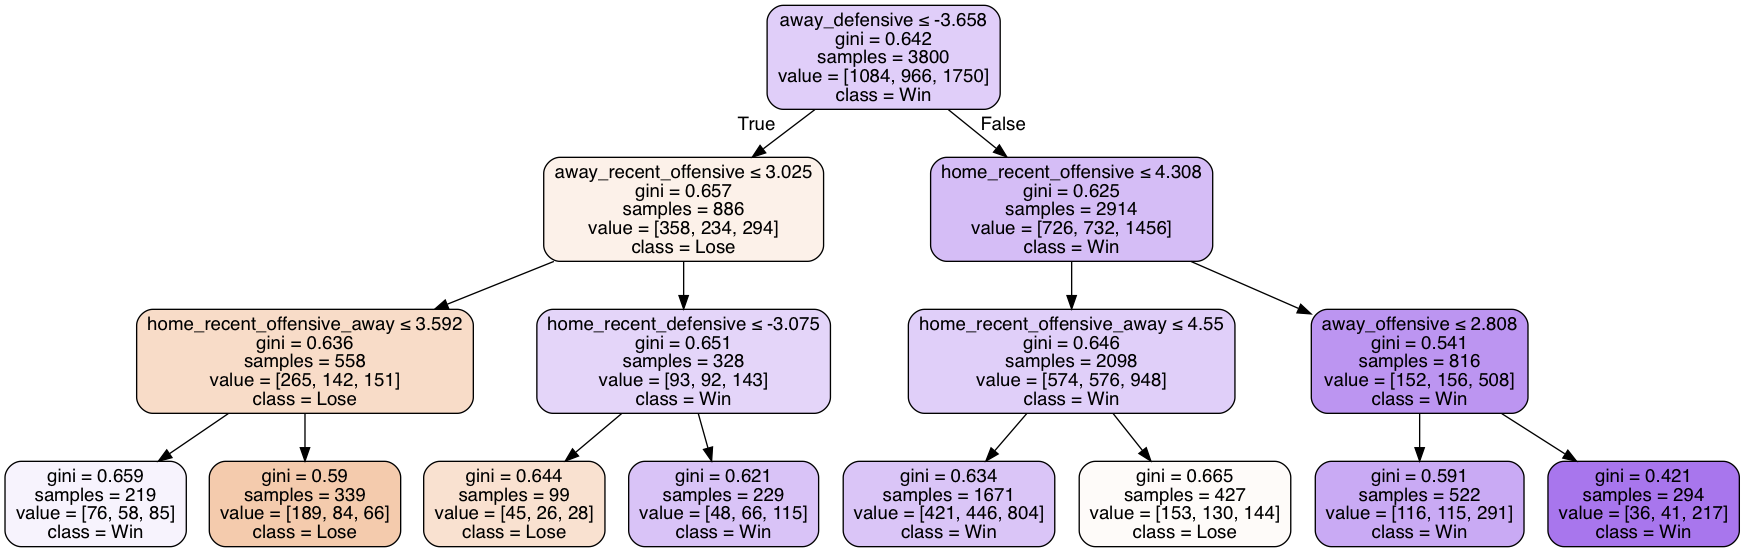

In [76]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = col_names, class_names = ['Lose', 'Draw', 'Win'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [ ]:
clf.feature_importances_

## Future facing

Right, now we're going to look at predicting the future odds!

In [54]:
diff_from_mean = team_elo.elo.values - np.mean(team_elo.elo.values)
other_expected = team_elo.elo.values - diff_from_mean/3
other_expected

array([1115.17189608, 1048.67342455,  932.81278414,  996.94046292,
        942.5548528 , 1009.19758199,  946.45291921,  995.94644155,
        959.66123394, 1078.79767564,  948.66420314, 1103.62192019,
        987.12287433, 1122.97964919,  950.67485554,  996.94901889,
       1186.20408566,  993.22188058,  995.31557455,  991.32144393,
        999.87719827,  997.2723188 ,  997.27285867,  975.43879933,
        967.77313125,  938.75834081,  989.93934885,  967.77333646,
       1011.09533552,  983.98749637,  985.2984409 , 1001.02429955,
        951.65024932,  981.79614108,  957.40618082,  991.35174517])

In [57]:
diff_from_mean = team_elo.elo.values - np.mean(team_elo.elo.values)
expected = team_elo.elo.values - diff_from_mean/3
expected

array([1089.65088065, 1047.19349821,  951.62138106,  990.80379653,
        957.89316286, 1007.42242225,  964.80133508,  996.34471428,
        967.75528577, 1073.21081485,  960.87735609, 1083.47840699,
        990.01573932, 1097.27282542,  956.59221277,  997.56338971,
       1138.10241065,  995.15954518,  995.60445907,  993.62412402,
        998.77315505,  998.36227449,  998.16926121,  980.81701616,
        976.46793867,  955.22821367,  993.04307241,  976.11126115,
        991.81506108,  989.5680383 ,  994.9527363 ,  992.15564673,
        963.04404609,  983.64766815,  969.43909838,  983.41775139])

In [61]:
diff_from_mean = team_elo.elo.values - np.mean(team_elo.elo.values)
final_expected = team_elo.elo.values - diff_from_mean/3
final_expected

array([1130.70708888, 1047.2551997 ,  910.06174064, 1015.92497259,
        926.88540832, 1015.92495266,  926.8735897 ,  996.41898079,
        949.61580824, 1071.28518937,  945.15053981, 1109.3056296 ,
        986.73191254, 1141.15086238,  969.14517324,  996.97360831,
       1226.63651913,  990.778708  ,  995.9621481 ,  989.36229178,
        982.24119015,  995.54332987,  996.538263  ,  971.42377441,
        958.31042936,  908.89234871,  987.00103657,  969.44504027,
       1043.45578411,  977.91597548,  965.96187698, 1013.91783526,
        942.34456534,  987.01130645,  952.44042668, 1005.40649359])

In [62]:
new_elos = pd.DataFrame({'expected': expected, 'other_expected': other_expected, 'final_expected': final_expected, 'team_long_name': team_elo.team_long_name})
new_elos.head()

,expected,other_expected,final_expected,team_long_name
0,1089.650881,1115.171896,1130.707089,Manchester United
1,1047.193498,1048.673425,1047.255200,Arsenal
2,951.621381,932.812784,910.061741,Sunderland
3,990.803797,996.940463,1015.924973,West Ham United
4,957.893163,942.554853,926.885408,Aston Villa


In [63]:
new_elos[new_elos.team_long_name == 'Manchester United']

,expected,other_expected,final_expected,team_long_name
0,1089.650881,1115.171896,1130.707089,Manchester United


In [64]:
new_elos[new_elos.team_long_name == 'Leicester City']

,expected,other_expected,final_expected,team_long_name
30,994.952736,985.298441,965.961877,Leicester City


In [47]:
expected_result(971.0439, 990.2999, 800)

0.4861477398925353

In [48]:
## Man U

### HW 74.78
### D 15.87
### L 9.34

## Betting odds
### HW 68.9
### D 23.8
### L 13.3

## Southampton
### HW 47
### D 29.5
### L 23.5

## Betting odds
### HW 57
### D 28.5
### L 21

## Newcastle
### HW 16.3
### D 20.4
### L 63.3

## Betting odds
### HW 29.4
### D 28.6
### L 48.7



print("So, I should bet on Manchester United to win, Burnley to win/draw and Tottenham to win.")

So, I should bet on Manchester United to win, Burnley to win/draw and Tottenham to win.


In [65]:
new_elos[new_elos.team_long_name.isin(['Watford', 'Brighton'])]

,expected,other_expected,final_expected,team_long_name
32,963.044046,951.650249,942.344565,Watford
33,983.647668,981.796141,987.011306,Brighton


In [66]:
final_frame[(final_frame.team_long_name == 'Watford') | (final_frame.team_long_name_away == 'Watford')].sort_values(by='date', ascending=False).head(1).home_recent_offensive
final_frame[(final_frame.team_long_name == 'Watford') | (final_frame.team_long_name_away == 'Watford')].sort_values(by='date', ascending=False).head(1).team_long_name

3459    Manchester United
Name: team_long_name, dtype: object

In [67]:
expected_result(948.640526, 976.718292, 800)

0.4798074118408002

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

ohe = OneHotEncoader()
le = LabelEncoder()
better = ohe.fit_transform(le.fit_transform(y).reshape(-1, 1))

In [ ]:
from sklearn.metrics import log_loss

log_loss(better.toarray(), lr.predict_proba(X))

In [ ]:
log_loss(better.toarray(), final_frame[['pct_win_prob', 'pct_draw_prob', 'pct_lose_prob']].values)

In [ ]:
from sklearn.model_selection import ShuffleSplit

rs = ShuffleSplit(n_splits=3, test_size=.2, random_state=0)
for train_index, test_index in rs.split(X):
    train_x = X[train_index]
    train_y = y[train_index]
    test_x = X[test_index]
    test_y = y[test_index]
    lr = LogisticRegression()
    lr.fit(train_x, train_y)
    
    ohe = OneHotEncoder()
    le = LabelEncoder()
    better = ohe.fit_transform(le.fit_transform(train_y).reshape(-1, 1))
    
    print("Train loss: {0:.3f}".format(log_loss(better.toarray(), lr.predict_proba(train_x))))
    
    test_better = ohe.transform(le.transform(test_y).reshape(-1, 1))
    
    print("Test loss: {0:.3f}".format(log_loss(test_better.toarray(), lr.predict_proba(test_x))))

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import ShuffleSplit

rs = ShuffleSplit(n_splits=3, test_size=.2, random_state=0)
for train_index, test_index in rs.split(X):
    train_x = X[train_index]
    train_y = y[train_index]
    test_x = X[test_index]
    test_y = y[test_index]
    lr = LogisticRegression()
    #pf = PolynomialFeatures()
    #new_train_x = pf.fit_transform(train_x)
    #new_test_x = pf.transform(test_x)
    lr.fit(train_x, train_y)
    
    ohe = OneHotEncoder()
    le = LabelEncoder()
    better = ohe.fit_transform(le.fit_transform(train_y).reshape(-1, 1))
    
    print("Train loss: {0:.3f}".format(log_loss(better.toarray(), lr.predict_proba(train_x))))
    
    test_better = ohe.transform(le.transform(test_y).reshape(-1, 1))
    
    print("Test loss: {0:.3f}".format(log_loss(test_better.toarray(), lr.predict_proba(test_x))))

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import ShuffleSplit

from sklearn.ensemble import RandomForestClassifier

rs = ShuffleSplit(n_splits=3, test_size=.1, random_state=382)
for train_index, test_index in rs.split(X):
    train_x = X[train_index]
    train_y = y[train_index]
    test_x = X[test_index]
    test_y = y[test_index]
    rf = RandomForestClassifier(max_depth=3, min_samples_split=3, min_samples_leaf=2)
    pf = PolynomialFeatures()
    new_train_x = pf.fit_transform(train_x)
    new_test_x = pf.transform(test_x)
    rf.fit(new_train_x, train_y)
    
    ohe = OneHotEncoder()
    le = LabelEncoder()
    better = ohe.fit_transform(le.fit_transform(train_y).reshape(-1, 1))
    
    print("Train loss: {0:.3f}".format(log_loss(better.toarray(), rf.predict_proba(new_train_x))))
    
    test_better = ohe.transform(le.transform(test_y).reshape(-1, 1))
    
    print("Test loss: {0:.3f}".format(log_loss(test_better.toarray(), rf.predict_proba(new_test_x))))

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import ShuffleSplit

from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import GradientBoostingClassifier

rs = ShuffleSplit(n_splits=3, test_size=.1, random_state=18)
for train_index, test_index in rs.split(X):
    train_x = X[train_index]
    train_y = y[train_index]
    test_x = X[test_index]
    test_y = y[test_index]
    gb = GradientBoostingClassifier(subsample=0.65, min_samples_leaf=3, min_samples_split=4)
    #pf = PolynomialFeatures(interaction_only=True, include_bias=False)
    #new_train_x = pf.fit_transform(train_x)
    #new_test_x = pf.transform(test_x)
    gb.fit(train_x, train_y)
    
    ohe = OneHotEncoder()
    le = LabelEncoder()
    better = ohe.fit_transform(le.fit_transform(train_y).reshape(-1, 1))
    
    print("Train loss: {0:.3f}".format(log_loss(better.toarray(), gb.predict_proba(train_x))))
    
    test_better = ohe.transform(le.transform(test_y).reshape(-1, 1))
    
    print("Test loss: {0:.3f}".format(log_loss(test_better.toarray(), gb.predict_proba(test_x))))

In [ ]:
for label, coef in zip(['bias', 'expected', 'other_expected',
       'final_expected', 'home_offensive', 'home_defensive',
       'away_offensive', 'away_defensive', 'home_recent_offensive',
       'home_recent_defensive', 'away_recent_offensive',
       'away_recent_defensive', 'home_recent_offensive_away',
       'home_recent_defensive_away', 'away_recent_offensive_away',
       'away_recent_defensive_away'], lr.coef_[0]):
    print("{0} : {1:.2f}".format(label, coef))

In [ ]:
lr.predict_proba(X)[:5]

In [ ]:
final_frame[['pct_win_prob', 'pct_draw_prob', 'pct_lose_prob']].values[:5]

In [ ]:
draw_predictions = final_frame[(lr.predict_proba(X)[:, 1] - final_frame.pct_draw_prob ) <= 0.]

In [ ]:
BET = 1
RUNNING_TOTAL = 0
CORRECT_COUNT = 0

for index, row in draw_predictions.sort_values(by='date').iterrows():
    odds = row.B365D
    result = row.label
    if result == 'Draw':
        CORRECT_COUNT += 1
        RUNNING_TOTAL += odds*BET
    else:
        RUNNING_TOTAL -= BET

In [ ]:
print("Money made: {0:.2f}".format(RUNNING_TOTAL))
print("Correct count: {0}".format(CORRECT_COUNT))

In [ ]:
final_frame.sort_values(by='B365D').head()

In [ ]:
with_team_names[['team_long_name', 'team_long_name_away', 'season', 'home_team_goal', 'away_team_goal', 'B365H', 'B365D', 'B365A']].sort_values(by='B365D').head()

In [ ]:
with_team_names[['team_long_name', 'team_long_name_away', 'season', 'home_team_goal', 'away_team_goal', 'B365H', 'B365D', 'B365A']].sort_values(by='B365D', ascending=False).head()

In [ ]:
final_frame.groupby('label').size() / final_frame.shape[0]

In [ ]:
final_frame.pct_draw_prob.describe()

In [ ]:
final_frame.loc[:, 'total_odds'] = final_frame[['B365H', 'B365D', 'B365A']].sum(axis=1)
final_frame.sort_values(by='total_odds', ascending=True).head()[['team_long_name', 'team_long_name_away', 'season', 'home_team_goal', 'away_team_goal', 'B365H', 'B365D', 'B365A']]

In [ ]:
final_frame.groupby('season').size()